In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from Bio import SeqIO
from Bio import SearchIO
import csv
import sqlite3
import time
from multiprocessing import Pool, cpu_count
import sys
from calc_icity_ import *
import ast
from collections import defaultdict

In [4]:
tnpB_path = "tnpB_icity_output.tsv"
tnpB_df = pd.read_csv(tnpB_path, sep = "\t").drop_duplicates()

In [5]:
tnpB_df.head()

,target_p30id,baitp100s,icity,numer,denom
0,0ff7ee64f28b75a0f2,['f4750da60b5fd6b492'],1.000000,1,1
1,39e68c61b9ecef36d5,['906bd0873066947631'],0.333333,1,3
2,661fd02903a3a6fd68,['261c51a94df2169e11'],1.000000,1,1
3,4ef07ad848ee560ff8,"['df4158dc559cea1ae8', '6f1dfb8e26c4639aad', '...",0.112601,42,373
4,fc82b7425b3af4e5f7,['fa509162f8954bc15c'],0.010989,1,91


In [6]:
def get_prot_sequence(pid):
    con=sqlite3.connect("80kprotein_stats.db")
    cur = con.cursor()
    cmd = "SELECT sequence FROM proteins WHERE pid = '%s'" % pid 
    #print(cmd)
    cur.execute(cmd)
    return str(cur.fetchone()[0])
    con.close()

In [7]:
tnpB_df = tnpB_df[tnpB_df["icity"] > .7].sort_values(["icity","numer"], ascending = False)
tnpB_df_0 = tnpB_df
tnpB_df_5 = tnpB_df[tnpB_df["denom"] > 5]
tnpB_df_10 = tnpB_df[tnpB_df["denom"] > 10]
tnpB_df_20 = tnpB_df[tnpB_df["denom"] > 20]
tnpB_df_40 = tnpB_df[tnpB_df["denom"] > 40]
tnpB_df_80 = tnpB_df[tnpB_df["denom"] > 80]
tnpB_df_160 = tnpB_df[tnpB_df["denom"] > 160]
tnpB_df_320 = tnpB_df[tnpB_df["denom"] > 320]
tnpB_df_l = [tnpB_df_0, tnpB_df_5, tnpB_df_10, tnpB_df_20, tnpB_df_40, tnpB_df_80, tnpB_df_160, tnpB_df_320]
[df.shape for df in tnpB_df_l]

[(115375, 5),
 (1753, 5),
 (858, 5),
 (412, 5),
 (175, 5),
 (65, 5),
 (21, 5),
 (5, 5)]

In [8]:
arg_suffixes = [str(i) for i in [0, 5, 10, 20, 40, 80, 160, 320]]

In [9]:
tnpB_multifaa_path_l = ["../tnpBs/data/hmmer_input_tnpb_" + i + ".faa" for i in arg_suffixes]
out_raw_path_l = ["../tnpBs/data/out_raw_path_" + i + ".out" for i in arg_suffixes]
out_clean_path_l = ["../tnpBs/output/out_raw_path_" + i + ".csv" for i in arg_suffixes]

In [10]:
def hmmsearch_tnpBneighb(tnpB_df, tnpB_multifaa_path, out_raw_path, out_clean_path):
    print("generating hmmsearch multifaa input file")
    with open(tnpB_multifaa_path, 'w') as outfile:
        for tnpBid in tnpB_df["target_p30id"]:
            tnpB_seq = get_prot_sequence(tnpBid)
            print(">" + tnpBid, file = outfile)
            print(tnpB_seq, file = outfile)
    pfam_command = "hmmsearch --cpu {threads} -E 1 --domtblout {outtbl} {hmmfile} {seqdb}".format(
    threads = cpu_count(), outtbl=out_raw_path, hmmfile='../tnpBs/data/Pfam-A.hmm', seqdb=tnpB_multifaa_path)
    print("running hmmsearch")
    os.system(pfam_command)
    print("formatting hmmsearch results")
    with open(out_raw_path, 'r') as infile, open(out_clean_path, "w") as outfile:
        print("query_id,query_accession, query_len,hit_id,hit_evalue,target_length", file=outfile)
        for qresult in SearchIO.parse(infile, 'hmmscan3-domtab'):
            query_id = qresult.id  #sequence ID from fasta
            query_accession = qresult.accession
            query_len = qresult.seq_len
            hits = qresult.hits
            num_hits = len(hits)
            if num_hits > 0:
                for i in range(0,num_hits): 
                    hit_evalue = hits[i].evalue
                    target_length = hits[i].seq_len
                    hit_id = hits[i].id
                    out_row = ",".join([query_id, query_accession, str(query_len), hit_id, str(hit_evalue), str(target_length)])
                    print(out_row, file=outfile)

In [11]:
# for i in range(len(tnpB_df_l)):
#     hmmsearch_tnpBneighb(tnpB_df_l[i], tnpB_multifaa_path_l[i], out_raw_path_l[i], out_clean_path_l[i])

## identify common pfam domains

In [12]:
df_pfam_320, df_pfam_160, df_pfam_80, df_pfam_40, df_pfam_20, df_pfam_10, df_pfam_5, df_pfam_0 = pd.read_csv(out_clean_path_l[7]), pd.read_csv(out_clean_path_l[6]), pd.read_csv(out_clean_path_l[5]), pd.read_csv(out_clean_path_l[4]), pd.read_csv(out_clean_path_l[3]), pd.read_csv(out_clean_path_l[2]), pd.read_csv(out_clean_path_l[1]), pd.read_csv(out_clean_path_l[0])
df_pfam_clustsize_list = [df_pfam_320, df_pfam_160, df_pfam_80, df_pfam_40, df_pfam_20, df_pfam_10, df_pfam_5, df_pfam_0]
# filter pfam df by evalues
df_pfam_evaluefiltered_list = [df[df["hit_evalue"] < 1e-4] for df in df_pfam_clustsize_list]
[df_pfam_320, df_pfam_160, df_pfam_80, df_pfam_40, df_pfam_20, df_pfam_10, df_pfam_5, df_pfam_0] = df_pfam_evaluefiltered_list

def dict_topn_pfam(df, n):
    queryid_frequency_dict = {}
    for i in range(n):
        key = df["query_id"].value_counts().index[i]
        value = df["query_id"].value_counts()[i] / len(df["query_id"]) * 100
        queryid_frequency_dict[key] = value
    return queryid_frequency_dict
dict_top10_320, dict_top10_160, dict_top10_80, dict_top10_40, dict_top10_20, dict_top10_10, dict_top10_5, dict_top10_0 = dict_topn_pfam(df_pfam_320, 10), dict_topn_pfam(df_pfam_160, 10), dict_topn_pfam(df_pfam_80, 10), dict_topn_pfam(df_pfam_40, 10), dict_topn_pfam(df_pfam_20, 10), dict_topn_pfam(df_pfam_10, 10), dict_topn_pfam(df_pfam_5, 10), dict_topn_pfam(df_pfam_0, 10)


In [13]:
all_dict_top10pfams = [dict_top10_320, dict_top10_160, dict_top10_80, dict_top10_40, dict_top10_20, dict_top10_10, dict_top10_5, dict_top10_0]
merged_dict_top10pfams = all_dict_top10pfams[0]
for dict_ in all_dict_top10pfams[1:]:
    merged_dict_top10pfams.update(dict_)

In [14]:
# argument for dict_globaltop_pfam()
list_top10pfams = list(merged_dict_top10pfams.keys())

In [15]:
df_pfam_10["query_id"].value_counts()[:10]

Y1_Tnp             67
Resolvase          46
MerR               26
HTH_17             26
OrfB_Zn_ribbon     25
MerR_1             25
OrfB_IS605         17
Acetyltransf_1     13
Acetyltransf_10    12
DUF2017            11
Name: query_id, dtype: int64

In [16]:
def dict_globaltop_pfam(df, pfamlist):
    queryid_frequency_dict = {}
    for pfam in pfamlist:
        key = pfam
        try:
            value = df["query_id"].value_counts()[pfam] / len(df["query_id"]) * 100
        except:
            value = 0
        queryid_frequency_dict[key] = value
    return queryid_frequency_dict

In [17]:
dict_pfamfreq_320, dict_pfamfreq_160, dict_pfamfreq_80, dict_pfamfreq_40, dict_pfamfreq_20, dict_pfamfreq_10, dict_pfamfreq_5, dict_pfamfreq_0 = dict_globaltop_pfam(df_pfam_320, list_top10pfams), dict_globaltop_pfam(df_pfam_160, list_top10pfams), dict_globaltop_pfam(df_pfam_80, list_top10pfams), dict_globaltop_pfam(df_pfam_40, list_top10pfams), dict_globaltop_pfam(df_pfam_20, list_top10pfams), dict_globaltop_pfam(df_pfam_10, list_top10pfams), dict_globaltop_pfam(df_pfam_5, list_top10pfams), dict_globaltop_pfam(df_pfam_0, list_top10pfams)


Text(0, 0.5, '% of the time a pfam hit is this pfam')

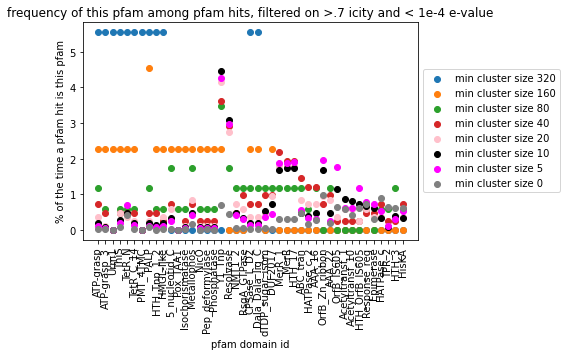

In [18]:
x_320, y_320 = list(dict_pfamfreq_320.keys()), list(dict_pfamfreq_320.values())
x_160, y_160 = list(dict_pfamfreq_160.keys()), list(dict_pfamfreq_160.values())
x_80, y_80 = list(dict_pfamfreq_80.keys()), list(dict_pfamfreq_80.values())
x_40, y_40 = list(dict_pfamfreq_40.keys()), list(dict_pfamfreq_40.values())
x_20, y_20 = list(dict_pfamfreq_20.keys()), list(dict_pfamfreq_20.values())
x_10, y_10 = list(dict_pfamfreq_10.keys()), list(dict_pfamfreq_10.values())
x_5, y_5 = list(dict_pfamfreq_5.keys()), list(dict_pfamfreq_5.values())
x_0, y_0 = list(dict_pfamfreq_0.keys()), list(dict_pfamfreq_0.values())
plt.scatter(x_320, y_320, label = "min cluster size 320")
plt.scatter(x_160, y_160, label = "min cluster size 160")
plt.scatter(x_80, y_80, label = "min cluster size 80")
plt.scatter(x_40, y_40, label = "min cluster size 40")
plt.scatter(x_20, y_20, label = "min cluster size 20", color = "pink")
plt.scatter(x_10, y_10, label = "min cluster size 10", color = "black")
plt.scatter(x_5, y_5, label = "min cluster size 5", color = "magenta")
plt.scatter(x_0, y_0, label = "min cluster size 0", color = "grey")
plt.xticks(rotation = 90)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("frequency of this pfam among pfam hits, filtered on >.7 icity and < 1e-4 e-value")
plt.xlabel("pfam domain id")
plt.ylabel("% of the time a pfam hit is this pfam")

Text(0, 0.5, '% of the time a pfam hit is this pfam')

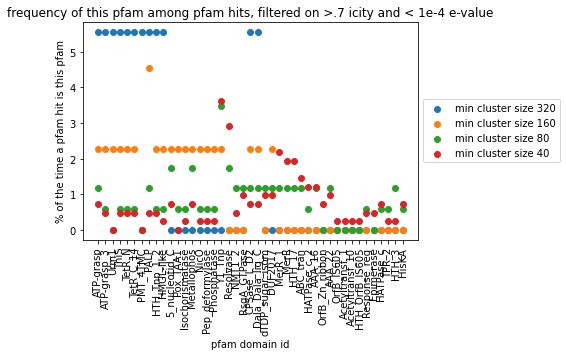

In [19]:
plt.scatter(x_320, y_320, label = "min cluster size 320")
plt.scatter(x_160, y_160, label = "min cluster size 160")
plt.scatter(x_80, y_80, label = "min cluster size 80")
plt.scatter(x_40, y_40, label = "min cluster size 40")
plt.xticks(rotation = 90)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("frequency of this pfam among pfam hits, filtered on >.7 icity and < 1e-4 e-value")
plt.xlabel("pfam domain id")
plt.ylabel("% of the time a pfam hit is this pfam")

Text(0, 0.5, '% of the time a pfam hit is this pfam')

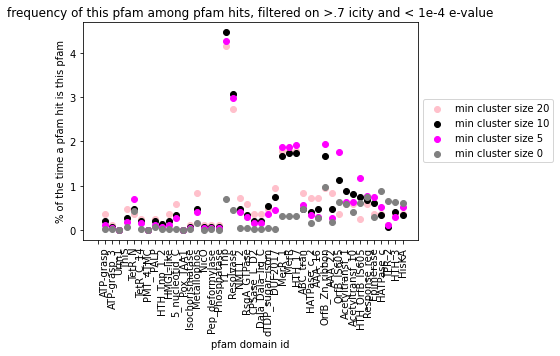

In [20]:
plt.scatter([" "], [1.6], color = "white")
plt.scatter(x_20, y_20, label = "min cluster size 20", color = "pink")
plt.scatter(x_10, y_10, label = "min cluster size 10", color = "black")
plt.scatter(x_5, y_5, label = "min cluster size 5", color = "magenta")
plt.scatter(x_0, y_0, label = "min cluster size 0", color = "grey")
plt.xticks(rotation = 90)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("frequency of this pfam among pfam hits, filtered on >.7 icity and < 1e-4 e-value")
plt.xlabel("pfam domain id")
plt.ylabel("% of the time a pfam hit is this pfam")

### explore tnpBs that colocalize


In [21]:
tnpB_df.shape[0]

115375

In [22]:
# get list of all tnpBs + similar proteins
tnpBs_list = []
infile_tnpBs = "tnpBs_in_testdb.p100.txt"
with open(infile_tnpBs, "r") as infile:
    lines = infile.readlines()
    for line in lines:
        p100 = line.split('\n')[0]
        tnpBs_list.append(p100)
perm_reps = get_permissive_rep_pool(tnpBs_list)
related_tnpB_baits = get_related_baits_pool(perm_reps)
target_p100ids = list(get_bait_neighb_pool(tnpBs_list))

In [23]:
related_tnpB_baits = set(related_tnpB_baits)
tnpBs_set = set(tnpBs_list)

In [24]:
# orfBids = df_pfam_0[df_pfam_0["query_id"] == "OrfB_IS605"]["hit_id"]
# orfBids
# sum([orfBid in tnpBs_list for orfBid in orfBids]), len(orfBids)

In [57]:
# ZOOM OUT: are tnpB neighbours closely related (have same p30) to tnpBs?
targetids_highicity = set(tnpB_df_10["target_p30id"])
targetids_istnpB = set()
for targetid in targetids_highicity:
    if targetid in related_tnpB_baits:
        targetids_istnpB.add(targetid)

In [58]:
len(targetids_highicity)

858

In [59]:
len(targetids_istnpB), len(targetids_highicity)

(113, 858)

In [28]:
list(targetids_istnpB)[0]

'2f8e37400827d267d5'

#### examine whether removing these colocalizing tnpBs change pfam results

In [32]:
def clean_pfamdf_notnpBs(df):
    return df.reset_index()[pd.Series([targetid not in targetids_istnpB for targetid in df["hit_id"]])]


In [33]:
df_pfam_10_clean = clean_pfamdf_notnpBs(df_pfam_10)

In [34]:
dict_topn_pfam(df_pfam_10_clean, 10), dict_topn_pfam(df_pfam_10, 10)

({'Y1_Tnp': 3.306392358559882,
  'Resolvase': 1.5429831006612784,
  'HTH_17': 1.1756061719324025,
  'MerR': 1.1021307861866276,
  'MerR_1': 1.1021307861866276,
  'Acetyltransf_1': 0.9551800146950772,
  'Acetyltransf_10': 0.881704628949302,
  'DUF2017': 0.8082292432035268,
  'Acetyltransf_9': 0.8082292432035268,
  'MFS_1': 0.7347538574577517},
 {'Y1_Tnp': 4.47561790247161,
  'Resolvase': 3.0728122912491647,
  'MerR': 1.736806947227789,
  'HTH_17': 1.736806947227789,
  'OrfB_Zn_ribbon': 1.6700066800267204,
  'MerR_1': 1.6700066800267204,
  'OrfB_IS605': 1.1356045424181698,
  'Acetyltransf_1': 0.8684034736138945,
  'Acetyltransf_10': 0.8016032064128256,
  'DUF2017': 0.7348029392117569})

In [170]:
# get output tnpB and hmm profile merged dataframes
tnpB_df_10['is_tnpB'] = [int(targetid in related_tnpB_baits) for targetid in tnpB_df_10['target_p30id']]
tnpB_df_10_merge = tnpB_df_10.set_index('target_p30id')
tnpB_df_10_out = df_pfam_10.join(tnpB_df_10_merge, on = 'hit_id', how = 'outer')
tnpB_df_10_out.to_csv("tnpB_targetgenes_pfam.csv")

In [169]:
df_pfam_10_out = df_pfam_10.join(tnpB_df_10_merge, on = 'hit_id', how = 'outer')


Text(0.5, 1.0, 'number of pfam hits for proteins that colocalize with tnpBs with >.7 icity, with cluster sizes > 10')

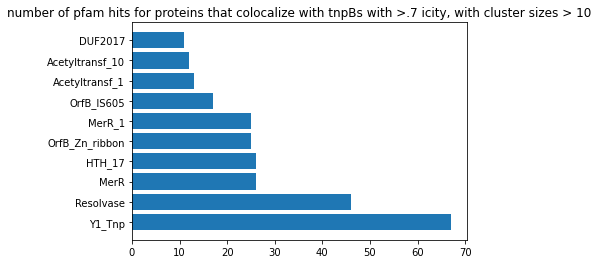

In [35]:
plt.barh(list(df_pfam_10["query_id"].value_counts().index)[:10], df_pfam_10["query_id"].value_counts()[:10])
plt.title("number of pfam hits for proteins that colocalize with tnpBs with >.7 icity, with cluster sizes > 10")

Text(0.5, 1.0, 'number of pfam hits for proteins that colocalize with tnpBs with >.7 icity, with cluster sizes > 10 and tnpBs filtered out')

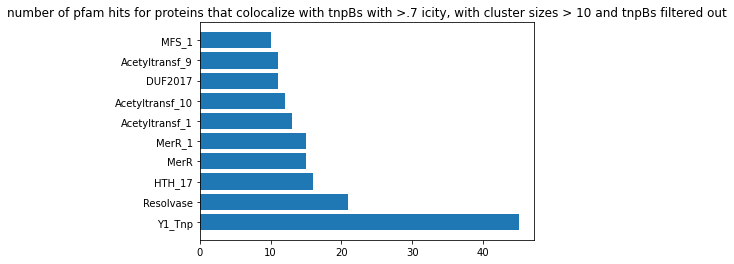

In [36]:
plt.barh(list(df_pfam_10_clean["query_id"].value_counts().index)[:10], df_pfam_10_clean["query_id"].value_counts()[:10])
plt.title("number of pfam hits for proteins that colocalize with tnpBs with >.7 icity, with cluster sizes > 10 and tnpBs filtered out")

In [37]:
def dict_topn_pfam(df, n):
    queryid_frequency_dict = {}
    for i in range(n):
        key = df["query_id"].value_counts().index[i]
        value = df["query_id"].value_counts()[i] / len(df["query_id"]) * 100
        queryid_frequency_dict[key] = value
    return queryid_frequency_dict
dict_top10_320, dict_top10_160, dict_top10_80, dict_top10_40, dict_top10_20, dict_top10_10, dict_top10_5, dict_top10_0 = dict_topn_pfam(df_pfam_320, 10), dict_topn_pfam(df_pfam_160, 10), dict_topn_pfam(df_pfam_80, 10), dict_topn_pfam(df_pfam_40, 10), dict_topn_pfam(df_pfam_20, 10), dict_topn_pfam(df_pfam_10, 10), dict_topn_pfam(df_pfam_5, 10), dict_topn_pfam(df_pfam_0, 10)


### get distribution of the number of tnpB neighbours that are also tnpBs

In [60]:
# count_neighbs_aretnpBs_ls = []
# count_zero_ids = []
# for targetid in targetids_istnpB:
#     count = 0
#     for neighbid in get_bait_neighbourhood(targetid):
#         count += neighbid in related_tnpB_baits
#     count_neighbs_aretnpBs_ls.append(count)
#     if count == 0:
#         count_zero_ids.append(targetid)

In [61]:
# ex_countzeroid = count_zero_ids[2]
# ex_countzeroid, ex_countzeroid in tnpBs_set

('29e8221912b9169758', False)

In [40]:
# tnpBtarget_neighb = get_bait_neighbourhood(ex_countzeroid)
# tnpBtarget_neighb, [neighbid in related_tnpB_baits for neighbid in tnpBtarget_neighb]

({'98744428d580d0e09e', 'a997828418ae7227f5'}, [False, False])

In [100]:
# target_nobait_baitlist = list(tnpB_df_10[tnpB_df_10['target_p30id'] == '29e8221912b9169758']['baitp100s'])

In [87]:
# get_bait_neighbourhood('98744428d580d0e09e')

{'29e8221912b9169758', 'a997828418ae7227f5'}

In [107]:
# plt.hist(count_neighbs_aretnpBs_ls)
# plt.title("distribution of the number of tnpBs neighbours that are also tnpBs, among all high-icity hits")

### explore data

In [50]:
tnpB_df_10.iloc[:,2]

199320    1.000000
339701    1.000000
10771     1.000000
14195     1.000000
2203      1.000000
            ...   
443058    0.702857
1511      0.702703
5884      0.702703
23728     0.702703
420       0.701299
Name: icity, Length: 858, dtype: float64

(array([2.76000e+02, 8.27000e+02, 1.66000e+02, 4.42000e+02, 2.33000e+02,
        2.38000e+02, 1.26000e+02, 6.10000e+01, 3.00000e+01, 1.12976e+05]),
 array([0.7012987 , 0.73116883, 0.76103896, 0.79090909, 0.82077922,
        0.85064935, 0.88051948, 0.91038961, 0.94025974, 0.97012987,
        1.        ]),
 <BarContainer object of 10 artists>)

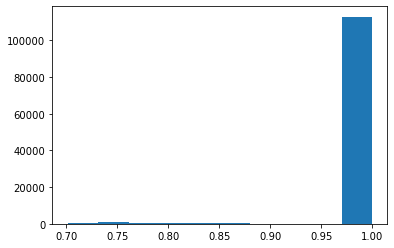

In [53]:
icity_s = tnpB_df_0.iloc[:,2]
plt.hist(icity_s)

In [50]:
# len_seq = []
# path_tnpB_multifaa = "hmmer_input_tnpb.faa"
# with open(path_tnpB_multifaa, 'w') as outfile:
#     for tnpBid in tnpB_df["target_p100id"]:
#         tnpB_seq = get_prot_sequence(tnpBid)
#         len_seq.append(len(tnpB_seq))
#         print(">" + tnpBid, file = outfile)
#         print(tnpB_seq, file = outfile)

Text(0.5, 1.0, 'distribution of protein lengths in tnpb neighbourhood')

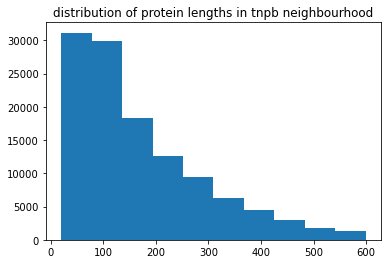

In [57]:
# plt.hist([l for l in len_seq if l < 600])
# plt.title("distribution of protein lengths in tnpb neighbourhood")

In [35]:
# os.system("wc -l hmmer_input_tnpb.faa")

244696 hmmer_input_tnpb.faa


0

In [36]:
# os.system("grep -c '>' hmmer_input_tnpb.faa")

122348


0

In [60]:
# os.system("tail -n 3 hmmer_input_tnpb.faa")

MTSTTVDAAAPRRGSSALAVLQRIGRSLMLPIAVLPAAALLLRFGQPDMLGADGLGWIRVAEVVGGAGQALFDHLPLLFAVGVAIGFAKKADGSTALAAVVGYLVFDQVSKIMFSHTDELKGNVLITKMVDGAPKEVIDFGAKNPTDVLGGILIGVVAALLYQRFYRVKLPTYLAFFGGRRFVPIITAVAALGIGVVIGFIWPVFGNWLTDFGNWITGAGALGAGIYGVVNRLLLPFGLHHIPNSLVWFVFGDYKGSDGVVHGEINRYLAGDPHAGGFLAGFFPVLMFGLPGAALAIWRAAPPHRRPAVGGIMISAALTAFVTGVTEPIEFAFMFVAPVLYAVHVVLTGISMAILEAAGAQLGFGFSAGGIDMLLNASKDNTKGLPLILGMGVLYFFIYYFVFKFLIVKFDFKTPGREPEDEDSVAADPDSNPELAAGTKPKKSRRRAAEDKAAEKEAGEEKAGDGTARPRDKGPAAPQDSPATS*
>f0bdeebd91979b22ba
MTTPTIELKPSSNPLSDAEREAILVKPGFGRYFTDHMVTIKWTDGRGWHDAQLVPYAPLSIDPANMTLHYGQEIFEGLKAYRQPDGTVATFRPEANAERFQSSARRLAMPELPVETFVAACDALVQQDAAWVPAHGGEESLYLRPFMIATEVGLGVRPSNEYLFLVIASPAGAYFPGGVKPVSIWLSEDRVRAVPGGMGDAKTGGNYAASLLAQAEAAAKGCDQVAYLDAVEHKWVEELGGMNLYFVYGNKIVTPALTGSLLAGITRDSLLRLAADLGYEPEENRVSIDQWRDDTANGTLTEVFACGTAAVITPVGTVKSASGEWTQGDGTPGPVTLRLRERLLDIQRGTAEDTHGWMHPLGXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXAEPVTRSRKGRAPGGRGLSALQDLERCSNLPAKGFIFSSLLVRVLL*


0

In [ ]:
# with open("test.out.csv", "w") as outfile:
#     pfam_command = "hmmsearch --cpu {threads} -E 1 --domtblout {outtbl} {hmmfile} {seqdb}".format(
#     threads = 32, outtbl=outfile, hmmfile='../tnpBs/data/Pfam-A.hmm', seqdb="hmmer_input_tnpb.faa")

# tic = time.perf_counter()
# pfam_command = "hmmsearch --cpu {threads} -E 1 --domtblout {outtbl} {hmmfile} {seqdb}".format(
# threads = 32, outtbl="test.out.tsv", hmmfile='../tnpBs/data/Pfam-A.hmm', seqdb="hmmer_input_tnpb.faa")
# print(pfam_command)

hmmsearch --cpu 32 -E 1 --domtblout test.out.tsv ../tnpBs/data/Pfam-A.hmm hmmer_input_tnpb.faa
0.0003365260017744731


In [ ]:
# with open("test.tmp.tsv", 'r') as infile, open("test.tmp.csv", "w") as outfile:
#     print("query_id,query_accession, query_len,hit_id,hit_evalue,target_length", file=outfile)
#     for qresult in SearchIO.parse(infile, 'hmmscan3-domtab'):
#         query_id = qresult.id  #sequence ID from fasta
#         query_accession = qresult.accession
#         query_len = qresult.seq_len
#         hits = qresult.hits
#         num_hits = len(hits)
#         if num_hits > 0:
#             for i in range(0,num_hits): 
#                 hit_evalue = hits[i].evalue
#                 # hmm_name = hits[i].accession
#                 target_length = hits[i].seq_len
#                 hit_id = hits[i].id
#                 out_row = ",".join([query_id, query_accession, str(query_len), hit_id, str(hit_evalue), str(target_length)])
#                 print(out_row, file=outfile)

In [153]:
with open("test.tmp.tsv", 'r') as infile:
    #print("query_id,query_accession, query_len,hit_id,hit_evalue,target_length", file=outfile)
    for qresult in SearchIO.parse(infile, 'hmmscan3-domtab'):
        query_id = qresult.id  #sequence ID from fasta
        query_accession = qresult.accession
        query_len = qresult.seq_len
        hits = qresult.hits
        for hit in hits:
            print(hit)
            print("hit!")
            for HSP in hit:  
                print(HSP.hit_start, HSP.hit_end, hit.evalue)
        asdf

Query: 1-cysPrx_C
       <unknown description>
  Hit: 3db6673226c6528dc1 (222)
       -
 HSPs: ----  --------  ---------  ------  ---------------  ---------------------
          #   E-value  Bit score    Span      Query range              Hit range
       ----  --------  ---------  ------  ---------------  ---------------------
          0   5.6e+04      -3.20       ?           [6:13]                 [8:14]
          1   5.2e-11      44.90       ?        [166:204]                 [0:38]
hit!
8 14 5.2e-11
0 38 5.2e-11
Query: 1-cysPrx_C
       <unknown description>
  Hit: 7c4f3de7f368f3d5c6 (149)
       -
 HSPs: ----  --------  ---------  ------  ---------------  ---------------------
          #   E-value  Bit score    Span      Query range              Hit range
       ----  --------  ---------  ------  ---------------  ---------------------
          0   1.9e-07      33.50       ?        [103:132]                 [0:31]
hit!
0 31 9.7e-08
Query: 1-cysPrx_C
       <unknown description>

NameError: name 'asdf' is not defined